In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/COOP.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,10.20,10.32,9.48,9.72,9.72,64700
1,1/3/2013,9.60,9.84,9.48,9.60,9.60,21600
2,1/4/2013,9.48,9.96,9.48,9.48,9.48,8000
3,1/7/2013,9.48,9.60,9.00,9.36,9.36,116100
4,1/8/2013,9.48,9.48,7.80,8.40,8.40,20800


In [3]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 10
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: 68.309984.3, cost: 0.001108, total money: 10068.309984
epoch: 20, total rewards: 101.399994.3, cost: 0.001050, total money: 10101.399994
epoch: 30, total rewards: 90.549994.3, cost: 0.000997, total money: 10090.549994
epoch: 40, total rewards: 99.389996.3, cost: 0.000948, total money: 10086.649996
epoch: 50, total rewards: 84.219987.3, cost: 0.000903, total money: 10084.219987
epoch: 60, total rewards: 83.249978.3, cost: 0.000854, total money: 10057.839978
epoch: 70, total rewards: 98.569987.3, cost: 0.000827, total money: 10073.119987
epoch: 80, total rewards: 214.309992.3, cost: 0.000897, total money: 10201.569992
epoch: 90, total rewards: 263.009981.3, cost: 0.000960, total money: 10237.559981
epoch: 100, total rewards: 304.649985.3, cost: 0.000913, total money: 10200.589986
epoch: 1

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 5: buy 1 unit at price 8.040000, total balance 9991.960000
day 6: buy 1 unit at price 8.640000, total balance 9983.320000
day 7, sell 1 unit at price 9.360000, investment 16.417907 %, total balance 9992.679999,
day 8, sell 1 unit at price 9.000000, investment 4.166663 %, total balance 10001.679999,
day 10: buy 1 unit at price 9.600000, total balance 9992.079999
day 12, sell 1 unit at price 9.960000, investment 3.749996 %, total balance 10002.039999,
day 14: buy 1 unit at price 10.080000, total balance 9991.959999
day 15, sell 1 unit at price 9.960000, investment -1.190475 %, total balance 10001.919999,
day 17: buy 1 unit at price 9.960000, total balance 9991.959999
day 19: buy 1 unit at price 9.360000, total balance 9982.599999
day 20: buy 1 unit at price 9.480000, total balance 9973.120000
day 22, sell 1 unit at price 9.000000, investment -9.638555 %, total balance 9982.120000,
day 23: buy 1 unit at price 9.000000, total balance 9973.120000
day 25: buy 1 unit at price 9.840000, to

day 308, sell 1 unit at price 38.880001, investment -2.114804 %, total balance 10146.040000,
day 309, sell 1 unit at price 38.279999, investment 0.314463 %, total balance 10184.319999,
day 311, sell 1 unit at price 39.000000, investment -4.411763 %, total balance 10223.319999,
day 313: buy 1 unit at price 38.759998, total balance 10184.560000
day 314: buy 1 unit at price 40.560001, total balance 10143.999999
day 317: buy 1 unit at price 39.599998, total balance 10104.400001
day 319, sell 1 unit at price 39.480000, investment -2.083334 %, total balance 10143.880000,
day 320, sell 1 unit at price 39.360001, investment 1.547994 %, total balance 10183.240001,
day 321: buy 1 unit at price 39.000000, total balance 10144.240001
day 322: buy 1 unit at price 37.799999, total balance 10106.440002
day 324: buy 1 unit at price 37.439999, total balance 10069.000003
day 325: buy 1 unit at price 37.200001, total balance 10031.800002
day 327, sell 1 unit at price 37.799999, investment -6.804739 %, tot

day 494: buy 1 unit at price 21.959999, total balance 9461.919990
day 495: buy 1 unit at price 21.840000, total balance 9440.079989
day 496: buy 1 unit at price 22.559999, total balance 9417.519990
day 497: buy 1 unit at price 28.080000, total balance 9389.439990
day 498, sell 1 unit at price 25.680000, investment -12.653059 %, total balance 9415.119990,
day 499, sell 1 unit at price 25.680000, investment -13.008130 %, total balance 9440.799991,
day 500: buy 1 unit at price 25.200001, total balance 9415.599990
day 502, sell 1 unit at price 25.320000, investment -10.212769 %, total balance 9440.919990,
day 503, sell 1 unit at price 24.600000, investment -10.869565 %, total balance 9465.519990,
day 504: buy 1 unit at price 26.400000, total balance 9439.119990
day 505, sell 1 unit at price 26.400000, investment 1.382483 %, total balance 9465.519990,
day 507: buy 1 unit at price 26.280001, total balance 9439.239989
day 509, sell 1 unit at price 26.280001, investment 6.829269 %, total balan

day 688: buy 1 unit at price 32.279999, total balance 8744.559987
day 689, sell 1 unit at price 32.279999, investment 8.467737 %, total balance 8776.839986,
day 690, sell 1 unit at price 31.799999, investment 5.999997 %, total balance 8808.639985,
day 691: buy 1 unit at price 31.200001, total balance 8777.439984
day 692: buy 1 unit at price 30.840000, total balance 8746.599984
day 693, sell 1 unit at price 30.959999, investment 0.389102 %, total balance 8777.559983,
day 694, sell 1 unit at price 30.840000, investment -0.772200 %, total balance 8808.399983,
day 695, sell 1 unit at price 31.080000, investment -0.766283 %, total balance 8839.479983,
day 696: buy 1 unit at price 31.080000, total balance 8808.399983
day 697: buy 1 unit at price 31.080000, total balance 8777.319983
day 698: buy 1 unit at price 30.959999, total balance 8746.359984
day 702: buy 1 unit at price 29.520000, total balance 8716.839984
day 703: buy 1 unit at price 30.000000, total balance 8686.839984
day 706, sell 1

day 897: buy 1 unit at price 27.719999, total balance 8804.319980
day 898, sell 1 unit at price 28.559999, investment 1.276591 %, total balance 8832.879979,
day 899, sell 1 unit at price 29.160000, investment 0.413219 %, total balance 8862.039979,
day 900, sell 1 unit at price 29.040001, investment 0.000000 %, total balance 8891.079980,
day 901: buy 1 unit at price 29.400000, total balance 8861.679980
day 902: buy 1 unit at price 28.799999, total balance 8832.879981
day 904, sell 1 unit at price 28.559999, investment -3.643725 %, total balance 8861.439981,
day 905: buy 1 unit at price 27.959999, total balance 8833.479981
day 906: buy 1 unit at price 27.959999, total balance 8805.519982
day 907: buy 1 unit at price 27.719999, total balance 8777.799983
day 909: buy 1 unit at price 27.840000, total balance 8749.959983
day 911, sell 1 unit at price 28.440001, investment -3.265303 %, total balance 8778.399983,
day 912: buy 1 unit at price 28.200001, total balance 8750.199983
day 914: buy 1 

day 1099: buy 1 unit at price 15.240000, total balance 8522.079976
day 1100: buy 1 unit at price 15.600000, total balance 8506.479976
day 1101: buy 1 unit at price 15.000000, total balance 8491.479976
day 1102: buy 1 unit at price 14.760000, total balance 8476.719976
day 1103: buy 1 unit at price 14.400000, total balance 8462.319976
day 1105, sell 1 unit at price 14.400000, investment -51.807229 %, total balance 8476.719976,
day 1106, sell 1 unit at price 15.000000, investment -47.478991 %, total balance 8491.719976,
day 1109: buy 1 unit at price 13.800000, total balance 8477.919975
day 1111, sell 1 unit at price 14.400000, investment -48.717950 %, total balance 8492.319975,
day 1112, sell 1 unit at price 15.000000, investment -45.652175 %, total balance 8507.319975,
day 1114: buy 1 unit at price 13.800000, total balance 8493.519975
day 1115: buy 1 unit at price 13.200000, total balance 8480.319975
day 1117: buy 1 unit at price 13.800000, total balance 8466.519975
day 1118, sell 1 unit

day 1293, sell 1 unit at price 14.880000, investment -4.615386 %, total balance 8402.679983,
day 1294, sell 1 unit at price 14.760000, investment -1.599998 %, total balance 8417.439983,
day 1295: buy 1 unit at price 15.000000, total balance 8402.439983
day 1296: buy 1 unit at price 15.480000, total balance 8386.959983
day 1297: buy 1 unit at price 15.000000, total balance 8371.959983
day 1298: buy 1 unit at price 15.480000, total balance 8356.479984
day 1299: buy 1 unit at price 15.240000, total balance 8341.239984
day 1301: buy 1 unit at price 16.080000, total balance 8325.159984
day 1302, sell 1 unit at price 16.680000, investment 13.008130 %, total balance 8341.839984,
day 1303, sell 1 unit at price 16.680000, investment 15.833339 %, total balance 8358.519985,
day 1305: buy 1 unit at price 17.040001, total balance 8341.479984
day 1306, sell 1 unit at price 16.680000, investment 20.869566 %, total balance 8358.159984,
day 1308: buy 1 unit at price 16.440001, total balance 8341.719984

day 1489: buy 1 unit at price 14.540000, total balance 7924.149985
day 1493: buy 1 unit at price 14.100000, total balance 7910.049985
day 1494: buy 1 unit at price 13.460000, total balance 7896.589984
day 1496: buy 1 unit at price 13.940000, total balance 7882.649985
day 1497, sell 1 unit at price 14.190000, investment 61.986292 %, total balance 7896.839984,
day 1498, sell 1 unit at price 13.820000, investment 53.555552 %, total balance 7910.659984,
day 1501: buy 1 unit at price 12.330000, total balance 7898.329984
day 1503: buy 1 unit at price 11.610000, total balance 7886.719985
day 1505, sell 1 unit at price 11.440000, investment 14.859433 %, total balance 7898.159984,
day 1507: buy 1 unit at price 11.300000, total balance 7886.859984
day 1508, sell 1 unit at price 11.720000, investment 33.789954 %, total balance 7898.579984,
day 1511: buy 1 unit at price 12.000000, total balance 7886.579984
day 1513: buy 1 unit at price 13.290000, total balance 7873.289984
day 1514, sell 1 unit at 

day 1685: buy 1 unit at price 10.310000, total balance 7733.399984
day 1686: buy 1 unit at price 10.550000, total balance 7722.849984
day 1688, sell 1 unit at price 10.490000, investment -37.110314 %, total balance 7733.339984,
day 1689: buy 1 unit at price 10.800000, total balance 7722.539984
day 1690: buy 1 unit at price 10.910000, total balance 7711.629984
day 1691, sell 1 unit at price 11.150000, investment -32.177620 %, total balance 7722.779984,
day 1692, sell 1 unit at price 11.200000, investment -32.853719 %, total balance 7733.979983,
day 1693, sell 1 unit at price 11.040000, investment -34.285712 %, total balance 7745.019983,
day 1694: buy 1 unit at price 11.190000, total balance 7733.829984
day 1695, sell 1 unit at price 10.910000, investment -35.059522 %, total balance 7744.739984,
day 1697: buy 1 unit at price 10.620000, total balance 7734.119984
day 1699: buy 1 unit at price 10.510000, total balance 7723.609984
day 1702: buy 1 unit at price 10.330000, total balance 7713.2

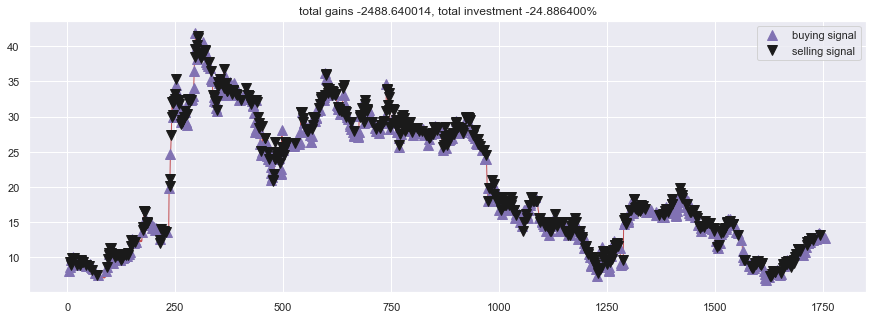

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=1)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()